### 1. Importaciones

In [179]:
# Importaciones necesarias
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import mlflow
import mlflow.sklearn
from scipy.stats import shapiro

# Configurar estilo de Seaborn
sns.set_theme(style="darkgrid")



### 2. Carga y Exploración de Datos

In [180]:
# Cargar el dataset
data = pd.read_csv("housing_train.csv", sep=",")
print("Primeras filas del dataset:")
display(data.head())

# Exploración básica
print("Información del dataset:")
print(data.info())
print("Estadísticas descriptivas:")
print(data.describe())


Primeras filas del dataset:


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-nul

### 3. Preprocesamiento de Datos

In [ ]:
# Eliminar la columna 'Id' y duplicados
data = data.drop(columns=["Id"], errors="ignore")
data = data.drop_duplicates()
print(f"Dimensiones después de limpiar: {data.shape}")

# Separar columnas categóricas de numéricas
num_features = data.select_dtypes(include=["number"]).columns
cat_features = data.select_dtypes(include=["object"]).columns


### 4. Distribución de caracteristicas Númericas

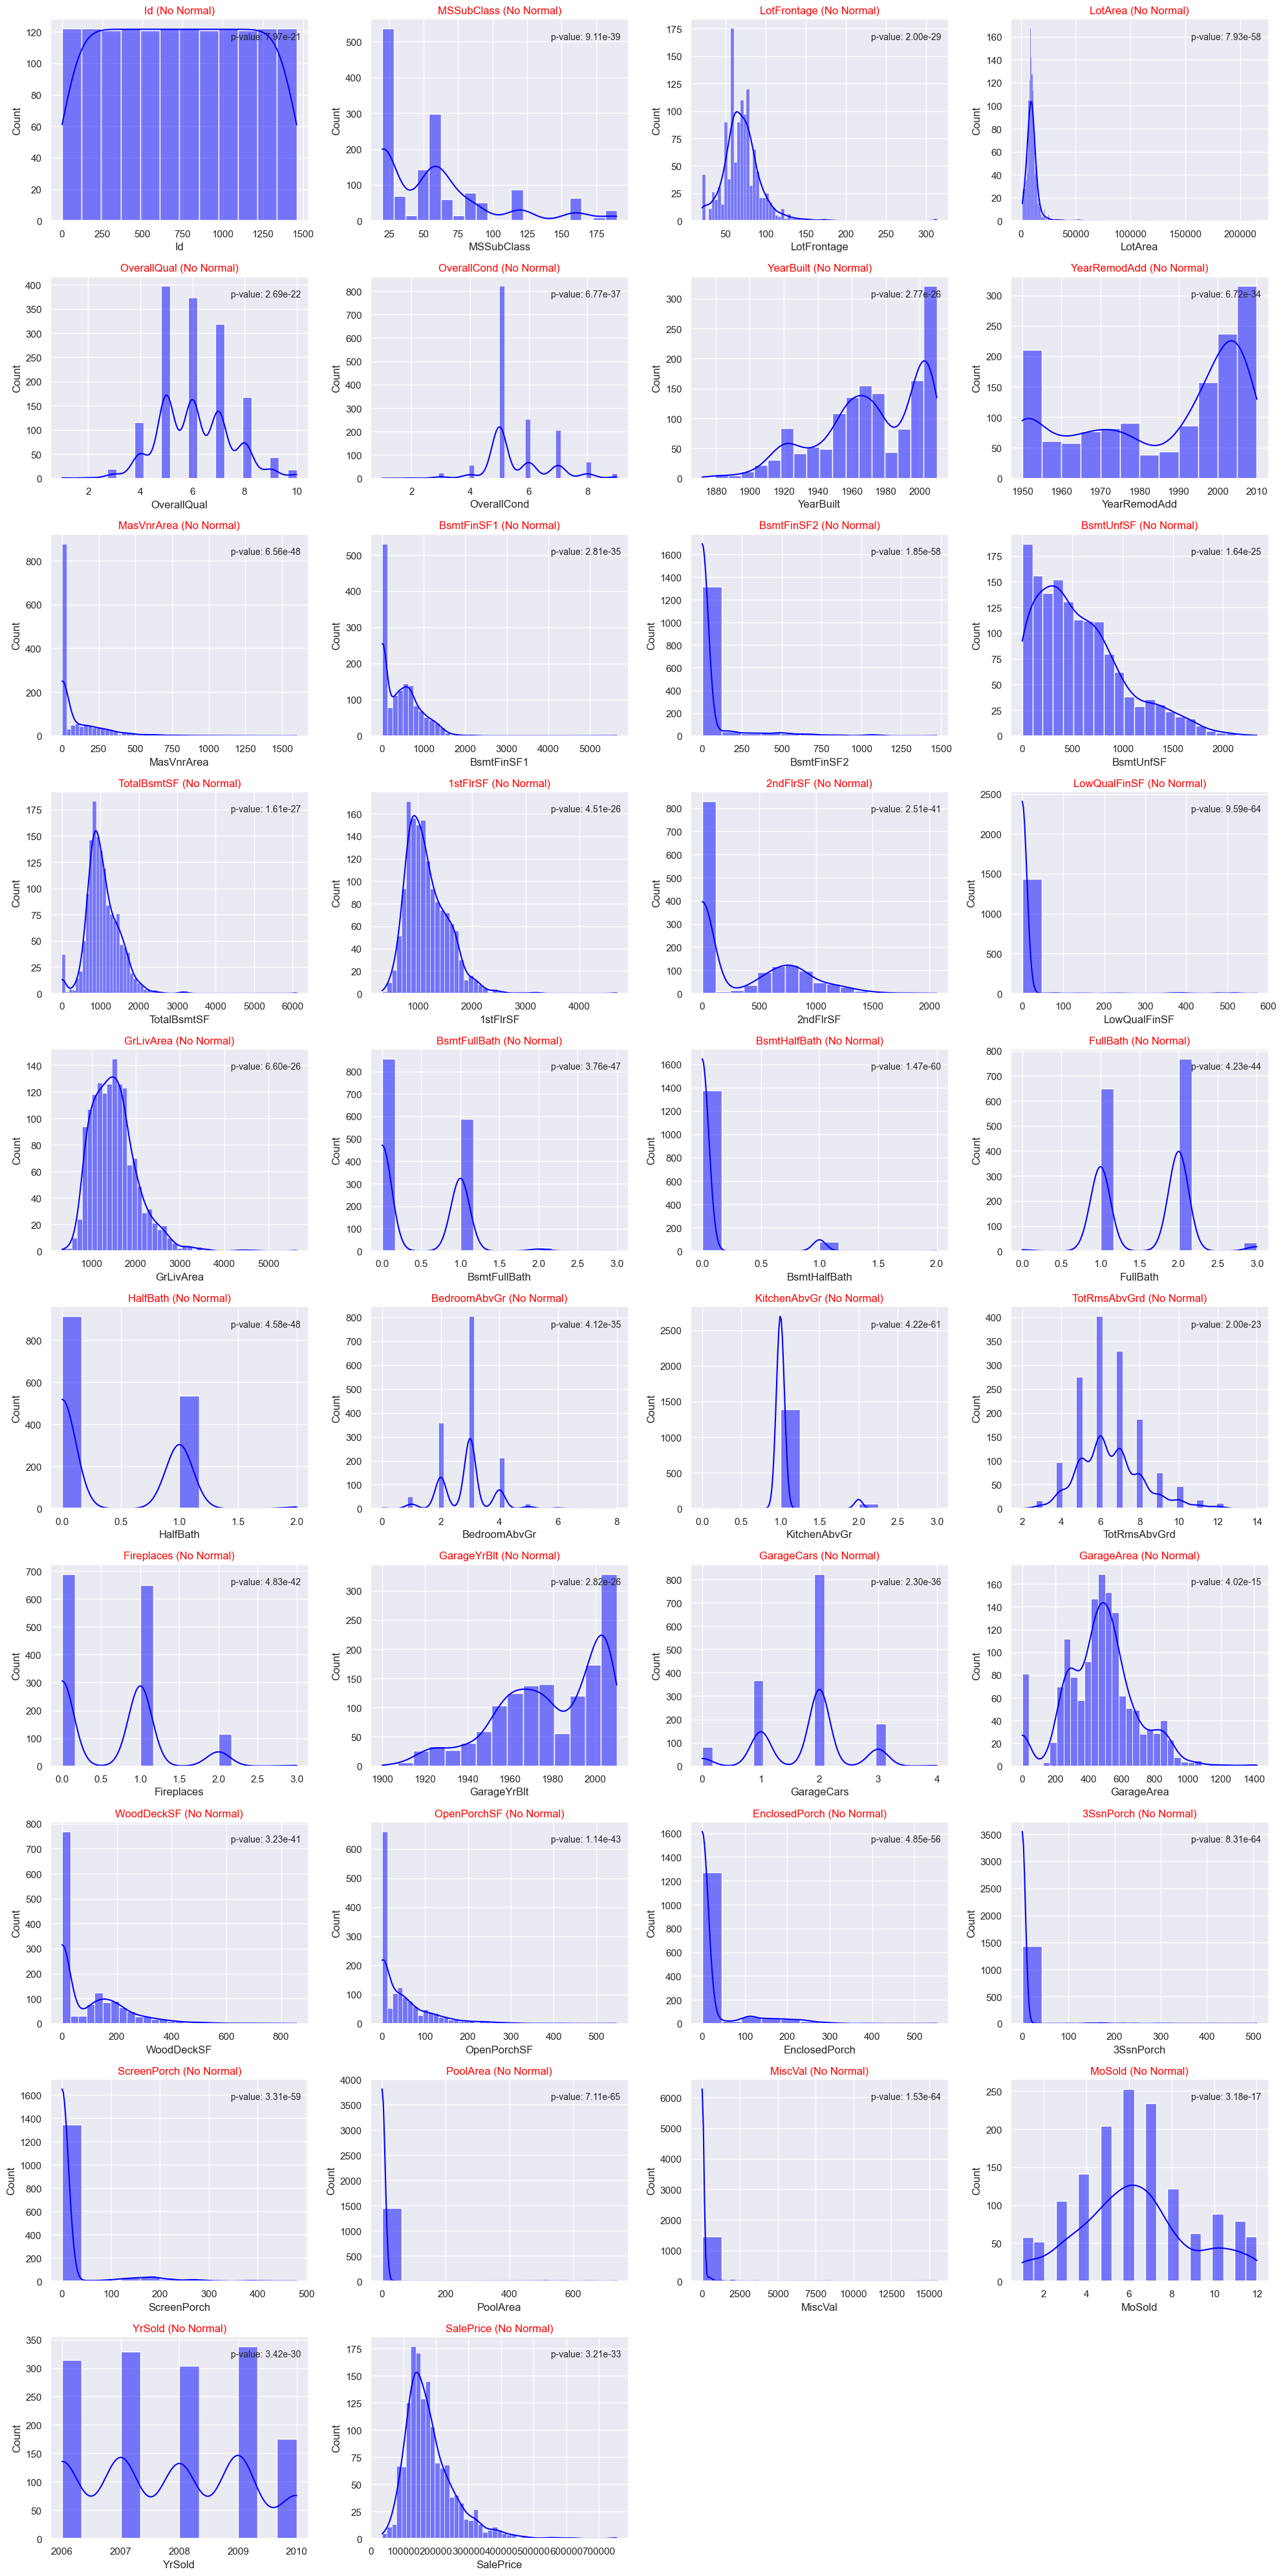

Porcentaje de valores nulos por columna:
LotFrontage     17.739726
Alley           93.767123
MasVnrType      59.726027
MasVnrArea       0.547945
BsmtQual         2.534247
BsmtCond         2.534247
BsmtExposure     2.602740
BsmtFinType1     2.534247
BsmtFinType2     2.602740
Electrical       0.068493
FireplaceQu     47.260274
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
PoolQC          99.520548
Fence           80.753425
MiscFeature     96.301370
dtype: float64
Características sesgadas: ['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'Encl

In [ ]:
# Diagnóstico inicial: visualizar distribuciones y valores nulos
def plot_distributions_and_nulls(data):
    """
    Grafica la distribución de todas las características numéricas y reporta valores nulos.
    """
    n_cols = 4
    n_rows = int(np.ceil(len(num_features) / n_cols))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
    axes = axes.flatten()
    
    skewed_features = []

    for i, col in enumerate(num_features):
        sns.histplot(data[col], kde=True, ax=axes[i], color='blue')
        axes[i].set_title(f"Distribución de {col}", fontsize=12)
        
        # Test de normalidad (Shapiro-Wilk)
        stat, p_value = shapiro(data[col].dropna())
        if p_value < 0.05:
            skewed_features.append(col)
            axes[i].set_title(f"{col} (No Normal)", color="red", fontsize=12)
        
        # Mostrar p-value en el gráfico
        axes[i].annotate(f"p-value: {p_value:.2e}", xy=(0.7, 0.9), xycoords='axes fraction', fontsize=10)
    
    for j in range(len(num_features), len(axes)):
        fig.delaxes(axes[j])
    
    fig.tight_layout()
    plt.show()
    
    return skewed_features

# Diagnóstico inicial
skewed_features = plot_distributions_and_nulls(data)
print(f"Características sesgadas: {skewed_features}")


### 5. Distribución de caracteristicas Categoricas

C:\Users\maria\AppData\Local\Temp\ipykernel_23048\4239948991.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=col, ax=axes[i], palette="viridis")
C:\Users\maria\AppData\Local\Temp\ipykernel_23048\4239948991.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha="right", fontsize=10)
C:\Users\maria\AppData\Local\Temp\ipykernel_23048\4239948991.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=col, ax=axes[i], palette="viridis")
C:\Users\maria\AppData\Local\Temp\ipykernel_23048\4239948991.py:18: UserWarning: 

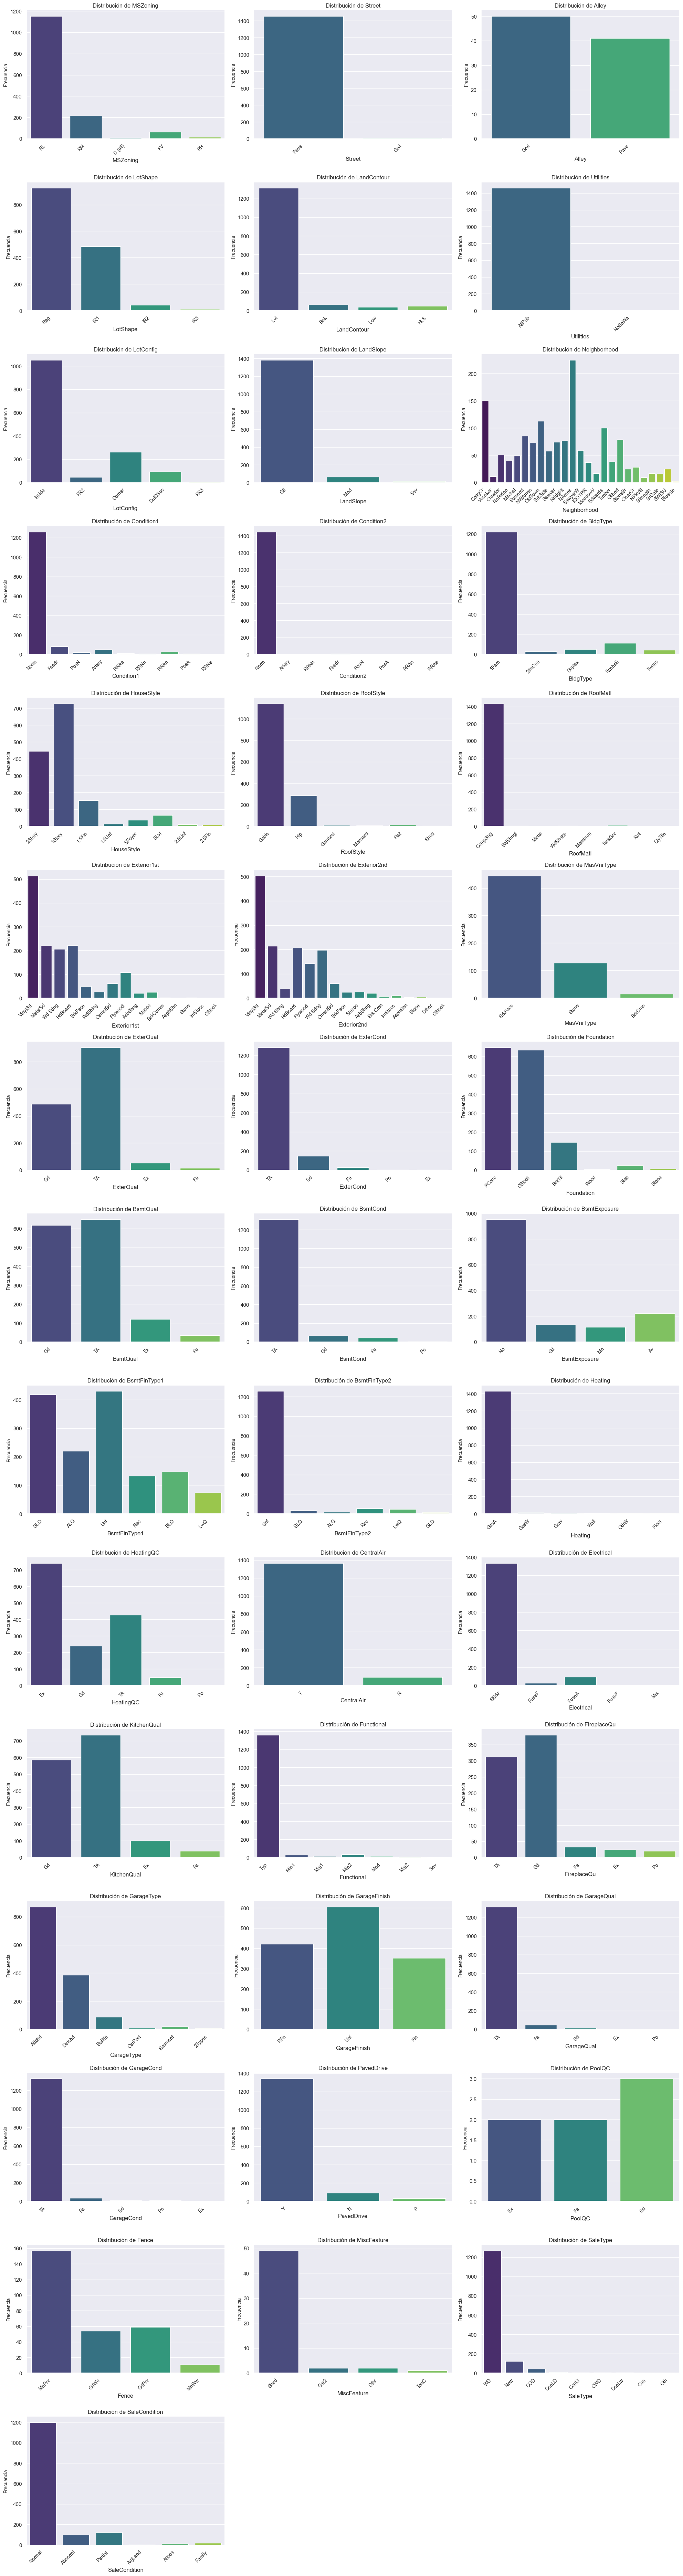

In [ ]:
def plot_categorical_bars(data):
    """
    Genera gráficas de barras para todas las variables categóricas.
    """
    
    # Configurar subplots
    n_cols = 3
    n_rows = int(np.ceil(len(cat_features) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
    axes = axes.flatten()
    
    # Crear gráficas de barras
    for i, col in enumerate(cat_features):
        sns.countplot(data=data, x=col, ax=axes[i], palette="viridis")
        axes[i].set_title(f"Distribución de {col}", fontsize=12)
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha="right", fontsize=10)
        axes[i].set_ylabel("Frecuencia", fontsize=10)
    
    # Eliminar ejes vacíos
    for j in range(len(cat_features), len(axes)):
        fig.delaxes(axes[j])
    
    fig.tight_layout()
    plt.show()

# Llamar a la función
plot_categorical_bars(data)


### 6. Eliminación de columnas Nulas Numéricas

In [ ]:
valores_nulos = num_features.isnull().sum()
porcentaje_nulos = (valores_nulos / len(data)) * 100
resumen_nulos = pd.DataFrame({
    'Valores Nulos': valores_nulos,
    'Porcentaje (%)': porcentaje_nulos
})

print(resumen_nulos[resumen_nulos['Valores Nulos'] > 0])

### 7. Eliminación de columnas Nulas Categóricas

### 5. Creación de Nuevas Características

In [ ]:
# Crear nuevas características basadas en el contexto del negocio
data["YearsSinceBuilt"] = 2024 - data["YearBuilt"]
data["YearsSinceRemodel"] = 2024 - data["YearRemodAdd"]
data["LotAreaPerGrLivArea"] = data["LotArea"] / data["GrLivArea"]
data["HasGarage"] = np.where(data["GarageArea"] > 0, 1, 0)
data["HasPool"] = np.where(data["PoolArea"] > 0, 1, 0)
data["HasFireplace"] = np.where(data["Fireplaces"] > 0, 1, 0)

# Verificar las nuevas características
print("Nuevas características creadas:")
display(data[["YearsSinceBuilt", "YearsSinceRemodel", "LotAreaPerGrLivArea", "HasGarage", "HasPool", "HasFireplace"]].head())


Nuevas características creadas:


,YearsSinceBuilt,YearsSinceRemodel,LotAreaPerGrLivArea,HasGarage,HasPool,HasFireplace
0,2021.847901,2021.847901,1.081191,1,1,1
1,2021.849479,2021.849479,1.106089,1,1,1
2,2021.848017,2021.847959,1.091734,1,1,1
3,2021.853134,2021.849833,1.086621,1,1,1
4,2021.848075,2021.848075,1.090038,1,1,1


### 6. Codificación de Variables Categóricas

In [ ]:
# Convertir variables categóricas en dummy variables
data = pd.get_dummies(data, drop_first=True)
print(f"Dimensiones después de codificación: {data.shape}")


Dimensiones después de codificación: (1460, 251)


### 7. Análisis de Correlación

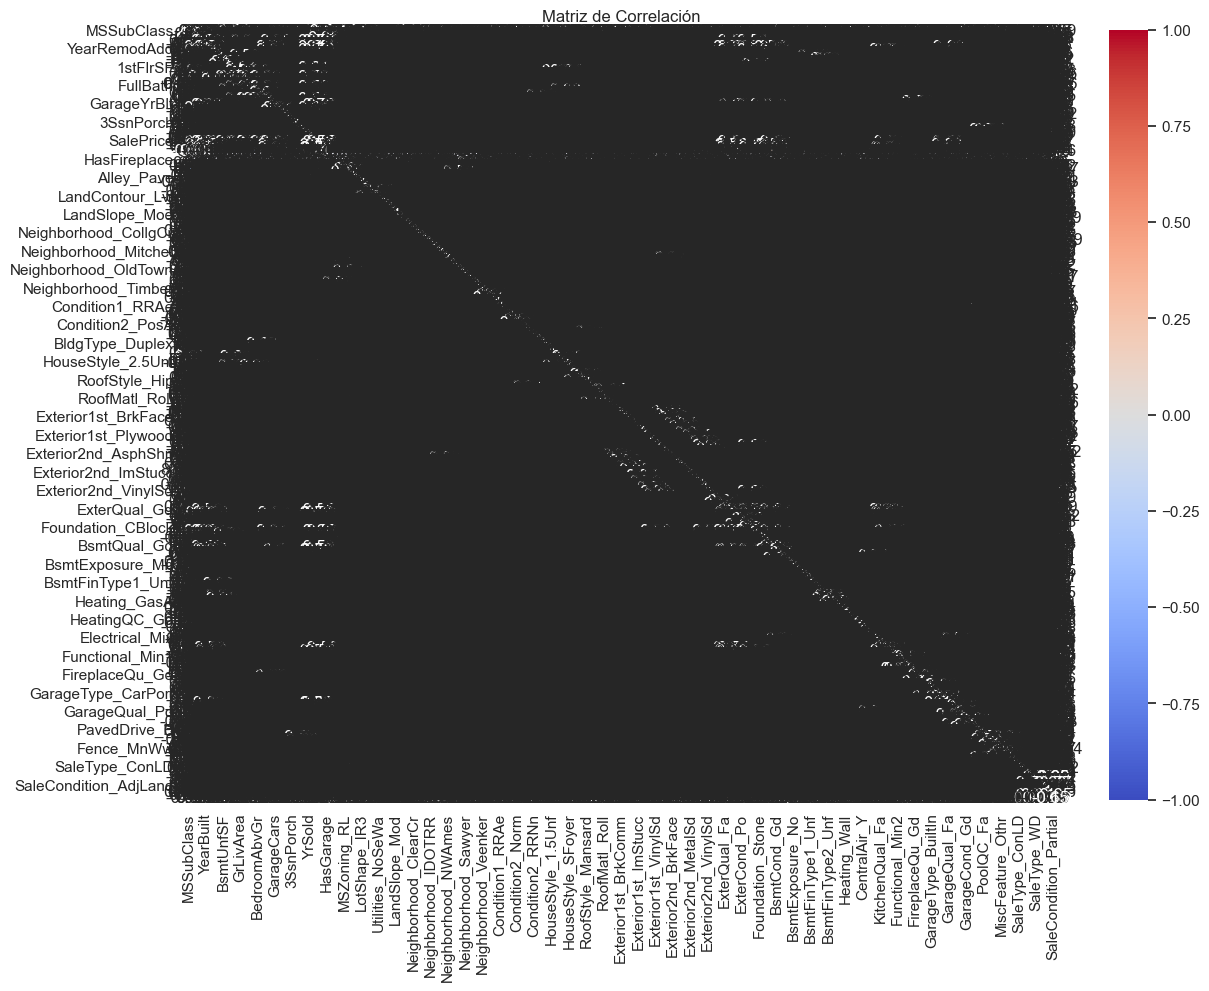

In [ ]:
# Generar la matriz de correlación
plt.figure(figsize=(14, 10))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm")
plt.title("Matriz de Correlación")
plt.show()


### 8. División del Dataset

In [ ]:
# Dividir en X (predictores) y y (variable objetivo)
X = data.drop(columns="SalePrice")
y = data["SalePrice"]

# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Dimensiones de entrenamiento: {X_train.shape}, Dimensiones de prueba: {X_test.shape}")


Dimensiones de entrenamiento: (1168, 250), Dimensiones de prueba: (292, 250)


### 9. Entrenamiento de Modelos

* Random Forest

In [ ]:
param_grid_rf = {
    "n_estimators": [50, 100, 150],
    "max_depth": [10, 20, 30],
    "min_samples_split": [5, 10],
    "min_samples_leaf": [2, 4],
}

grid_search_rf = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid_rf,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)
grid_search_rf.fit(X_train, y_train)

best_rf_model = grid_search_rf.best_estimator_
print("Mejores parámetros Random Forest:", grid_search_rf.best_params_)


Mejores parámetros Random Forest: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}


* XGBoost

In [ ]:
param_grid_xgb = {
    "max_depth": [3, 5],                 # Reducir opciones
    "learning_rate": [0.05, 0.1],       # Excluir valores muy bajos inicialmente
    "n_estimators": [50, 100],          # Fewer estimators para pruebas iniciales
    "subsample": [0.8],                 # Fijar en un valor razonable
    "colsample_bytree": [0.8],          # Fijar en un valor razonable
    "reg_alpha": [0.1],                 # Priorizar valores probados
    "reg_lambda": [0.1],                # Priorizar valores probados
}

grid_search_xgb = GridSearchCV(
    xgb.XGBRegressor(random_state=42),
    param_grid_xgb,
    cv=3,                              # Usar 3 particiones en lugar de 5
    scoring="neg_mean_squared_error",
    n_jobs=-1                          # Usar todos los núcleos disponibles
)

grid_search_xgb.fit(X_train, y_train)

best_xgb_model = grid_search_xgb.best_estimator_
print("Mejores parámetros XGBoost:", grid_search_xgb.best_params_)


Mejores parámetros XGBoost: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.8}


### 10. Evaluación de Modelos

In [ ]:
# Función para evaluar modelos
def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    preds_train = model.predict(X_train)
    preds_test = model.predict(X_test)

    rmse_train = np.sqrt(mean_squared_error(y_train, preds_train))
    rmse_test = np.sqrt(mean_squared_error(y_test, preds_test))
    r2 = r2_score(y_test, preds_test)

    print(f"{name} - RMSE Entrenamiento: {rmse_train}, RMSE Prueba: {rmse_test}, R²: {r2}")
    return rmse_test

# Evaluar Random Forest
evaluate_model("Random Forest", best_rf_model, X_train, X_test, y_train, y_test)

# Evaluar XGBoost
evaluate_model("XGBoost", best_xgb_model, X_train, X_test, y_train, y_test)


Random Forest - RMSE Entrenamiento: 0.005205865107649333, RMSE Prueba: 0.011582230588696433, R²: 0.8784347554680456
XGBoost - RMSE Entrenamiento: 0.005955308352818764, RMSE Prueba: 0.011117167004931098, R²: 0.8880012247177176


np.float64(0.011117167004931098)

### 11. Registro con MLFlow

In [ ]:
# Registro en MLFlow
mlflow.set_experiment("usa_housing_analysis")

# Registrar Random Forest
with mlflow.start_run():
    preds_rf = best_rf_model.predict(X_test)
    rmse_rf = np.sqrt(mean_squared_error(y_test, preds_rf))

    mlflow.log_param("Modelo", "Random Forest")
    mlflow.log_metric("RMSE", rmse_rf)
    mlflow.sklearn.log_model(best_rf_model, "random_forest_model")

# Registrar XGBoost
with mlflow.start_run():
    preds_xgb = best_xgb_model.predict(X_test)
    rmse_xgb = np.sqrt(mean_squared_error(y_test, preds_xgb))

    mlflow.log_param("Modelo", "XGBoost")
    mlflow.log_metric("RMSE", rmse_xgb)
    mlflow.sklearn.log_model(best_xgb_model, "xgboost_model")



2024/11/27 19:31:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/27 19:31:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


### 12. Análisis de Residuos

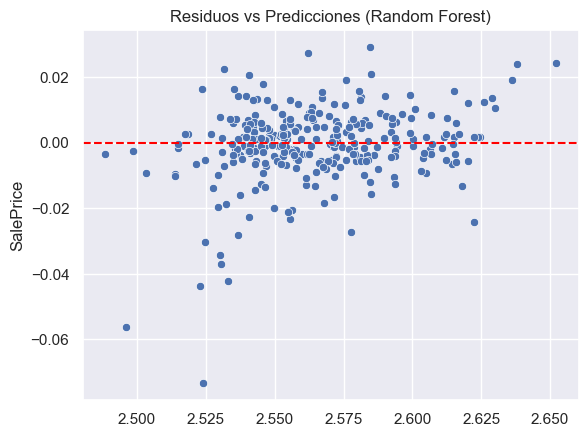

In [ ]:
# Análisis de residuos para Random Forest
preds = best_rf_model.predict(X_test)
residuals = y_test - preds

sns.scatterplot(x=preds, y=residuals)
plt.axhline(0, color="red", linestyle="--")
plt.title("Residuos vs Predicciones (Random Forest)")
plt.show()


Gráfica para Random Forest:


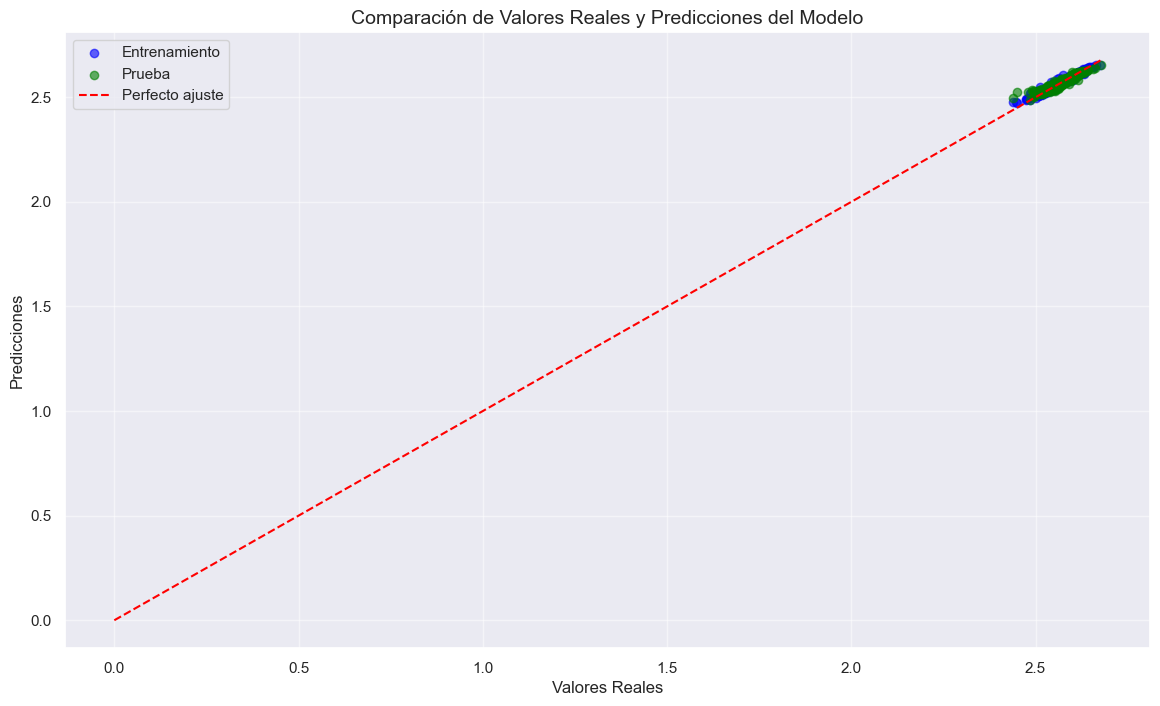

Gráfica para XGBoost:


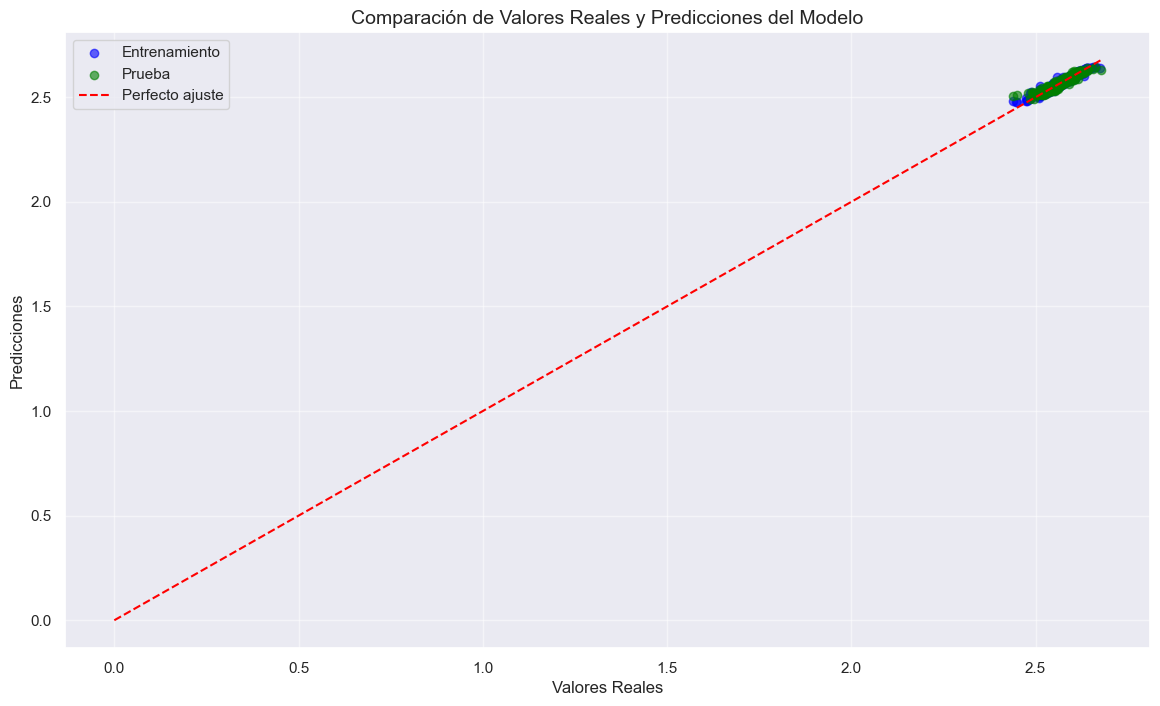

In [ ]:
def plot_predictions(model, X_train, X_test, y_train, y_test):
    """
    Grafica los datos de entrenamiento, prueba y las predicciones del modelo.
    """
    # Predicciones
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    
    plt.figure(figsize=(14, 8))
    
    # Datos de entrenamiento
    plt.scatter(y_train, train_preds, label="Entrenamiento", alpha=0.6, color="blue")
    
    # Datos de prueba
    plt.scatter(y_test, test_preds, label="Prueba", alpha=0.6, color="green")
    
    # Línea ideal
    max_value = max(y_train.max(), y_test.max())
    plt.plot([0, max_value], [0, max_value], linestyle="--", color="red", label="Perfecto ajuste")
    
    # Configuraciones de la gráfica
    plt.xlabel("Valores Reales", fontsize=12)
    plt.ylabel("Predicciones", fontsize=12)
    plt.title("Comparación de Valores Reales y Predicciones del Modelo", fontsize=14)
    plt.legend()
    plt.grid(alpha=0.5)
    plt.show()

# Llamar a la función con Random Forest
print("Gráfica para Random Forest:")
plot_predictions(best_rf_model, X_train, X_test, y_train, y_test)

# Llamar a la función con XGBoost (opcional)
print("Gráfica para XGBoost:")
plot_predictions(best_xgb_model, X_train, X_test, y_train, y_test)
